# AR(2) Model

This note simulates a basic AR(2).

$$y_t = \mu + \rho_1 y_{t-1} + \rho_2 y_{t-2} + \epsilon_t , \quad \epsilon_t \sim N_{0,\sigma^2}, \quad t=3,\dots,\tau$$

See the graphs below and code for information about the priors and inference, which is a structured (full-rank) VI procedure.

## Preliminaries

In [1]:
# !pip3 install http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl >/dev/null && echo OK
# !pip3 install torchvision > /dev/null && echo OK
# !pip3 uninstall -y ptvi >/dev/null && echo OK
# !pip3 install git+https://github.com/kuperov/ptvi.git  >/dev/null && echo OK

## Model definition

In [2]:
import math
import torch
from torch.distributions import Normal, LogNormal, Beta
from ptvi import *


class AR2(Model):

    name = 'AR(2) model'
    has_observation_error = False
    μ = global_param(Normal(0, 1))
    ρ1 = global_param(Beta(2, 2), transform='logit', rename='φ1')
    ρ2 = global_param(Beta(2, 2), transform='logit', rename='φ2')
    σ = global_param(LogNormal(0, 1), transform='log', rename='η')

    def ln_joint(self, y, ζ):
        μ, (ρ1, φ1), (ρ2, φ2), (σ, η) = self.unpack(ζ)
        llhood = Normal(μ + y[1:-1] * ρ1 + y[:-2] * ρ2, σ).log_prob(y[2:]).sum()
        lprior = (
            self.μ_prior.log_prob(μ)
            + self.φ1_prior.log_prob(φ1)
            + self.φ2_prior.log_prob(φ2)
            + self.η_prior.log_prob(η)
        )
        return llhood + lprior

    def simulate(self, μ, ρ1, ρ2, σ):
        assert self.input_length is not None
        y = torch.empty((self.input_length,))
        y[0] = Normal(
            μ / (1 - ρ1 - ρ2),
            σ * math.sqrt((1 - ρ2)/((1 + ρ2)*((1 - ρ2)**2 - ρ1**2)))).sample()
        y[1] = μ + ρ1 * y[0] + Normal(
            μ / (1 - ρ2), σ / math.sqrt(1 - ρ2**2)).sample()
        for i in range(2, self.input_length):
            y[i] = μ + ρ1*y[i-1] + ρ2*y[i-2] + Normal(0, σ).sample()
        return y

    def forecast(self, ζ: torch.Tensor, y: torch.Tensor, fc_steps: int) -> \
            torch.Tensor:
        assert fc_steps >= 1, 'Must forecast at least 1 step.'
        μ, (ρ1, φ1), (ρ2, φ2), (σ, η) = self.unpack(ζ)
        fc = torch.empty((fc_steps,))
        fc[0] = μ + ρ1 * y[-1] + ρ2 * y[-2] + Normal(0, σ).sample()
        if fc_steps > 1:
            fc[1] = μ + ρ1 * fc[0] + ρ2 * y[-1] + Normal(0, σ).sample()
        for i in range(2, fc_steps):
            fc[i] = μ + ρ1 * fc[i-1] + ρ2 * fc[i-2] + Normal(0, σ).sample()
        return fc

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

Define the true parameter values and generate data.

In [4]:
μ, ρ1, ρ2, σ = 1.5, 0.2, 0.1, 1.5
τ = 1000
data_seed, algo_seed = 123, 123

In [5]:
torch.manual_seed(data_seed)
params = dict(μ=μ, ρ1=ρ1, ρ2=ρ2, σ=σ)
model = AR2(input_length=τ)
y = model.simulate(**params)

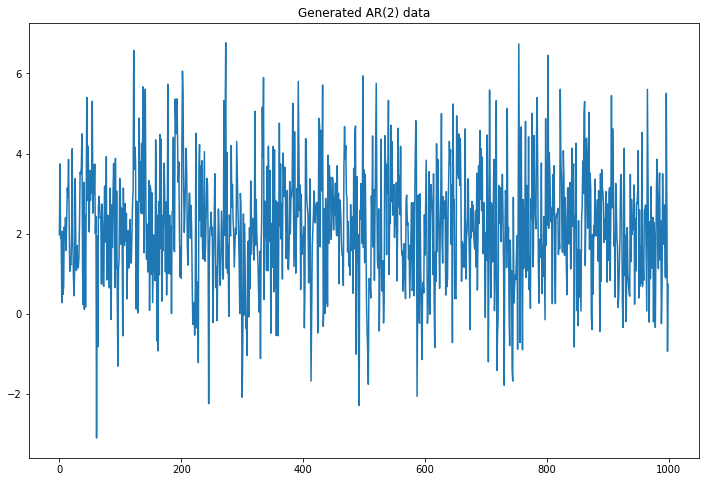

In [6]:
plt.plot(y.numpy())
plt.title('Generated AR(2) data');

## MAP inference

In [7]:
mfit = map(model, y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
MAP inference with L-BGFS: AR(2) model
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. log joint = -2408.1624
       1. log joint = -1820.2708
       2. log joint = -1820.2708
Convergence criterion met.
       2. log joint = -1820.2708
Completed 3 iterations in 0.05s @ 63.14 i/s.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [8]:
mfit.summary()

,mean,sd
μ,1.569140,0.047006
ρ1,0.159551,0.018855
ρ2,0.111243,0.016200
σ,1.480186,0.036557


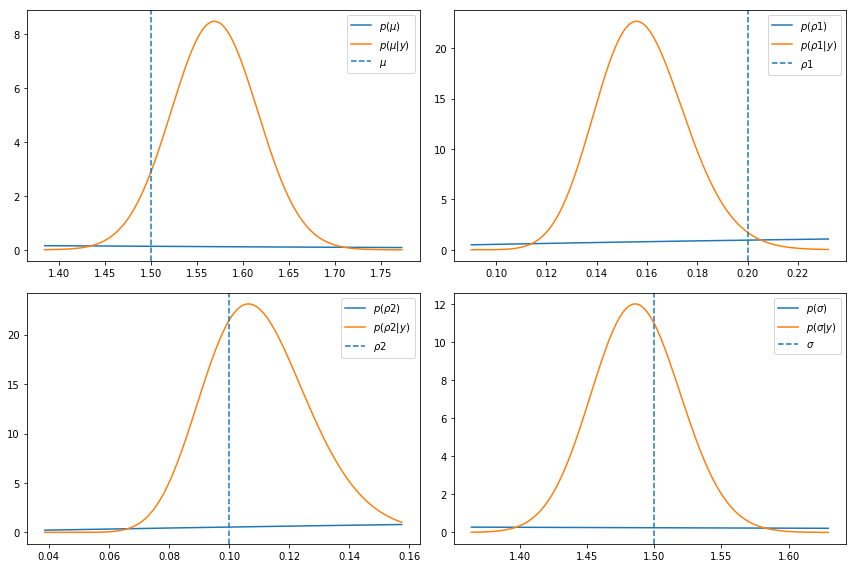

In [9]:
mfit.plot_global_marginals(**params)

## Variational inference (warm start)

We seed the variational inference using the MAP, which gives a really good speed-up.

In [10]:
torch.manual_seed(algo_seed)
u0, L0 = mfit.initial_conditions()
stop_h = SupGrowthStoppingHeuristic(skip=5, min_steps=15, patience=10)
vfit = sgvb(model, y, u0=u0, L0=L0, stop_heur=stop_h)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured SGVB Inference: AR(2) model
  - Estimating elbo with M=1;
  - Minimum supremum growth heuristic (min_steps=75, patience=10, skip=5, ε=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0
  - Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed elbo =-1827.23
       1. smoothed elbo =-1827.22
       2. smoothed elbo =-1827.29
       4. smoothed elbo =-1827.26
       8. smoothed elbo =-1827.02
      16. smoothed elbo =-1826.99
      32. smoothed elbo =-1827.59
      64. smoothed elbo =-1826.77
     128. smoothed elbo =-1827.41
Stopping heuristic criterion satisfied
     160. smoothed elbo =    -1826.49
Completed 161 iterations in 0.4s @ 404.99 i/s.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


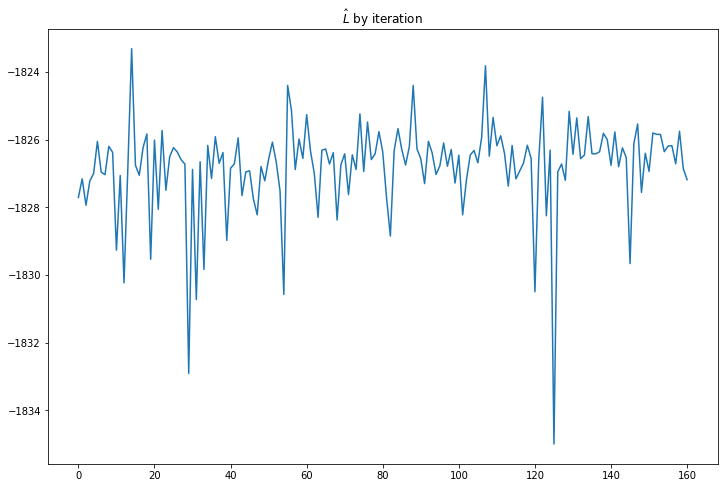

In [11]:
vfit.plot_elbos()

In [12]:
vfit.summary()

,mean,sd
μ,1.569727,0.068866
ρ1,0.155878,0.025962
ρ2,0.110569,0.026201
σ,1.483742,0.037574


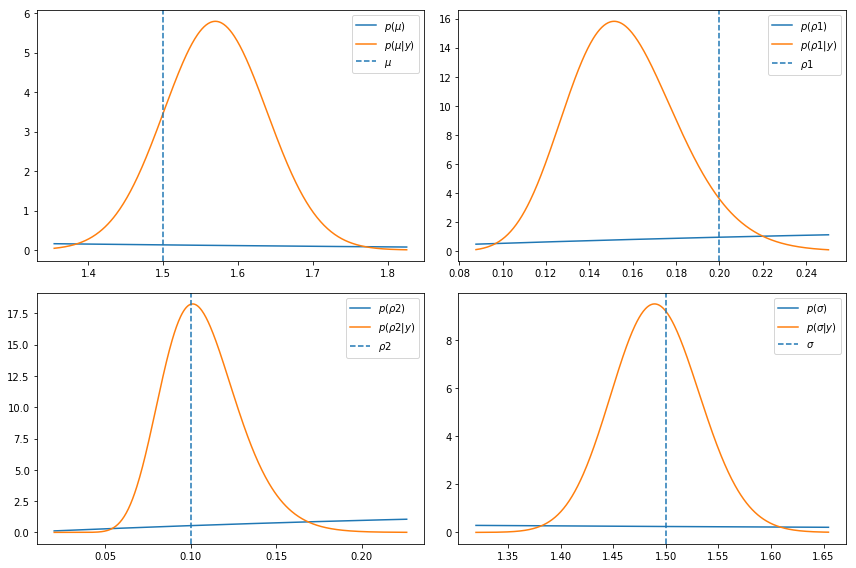

In [13]:
vfit.plot_global_marginals(**params)

### Forecasts

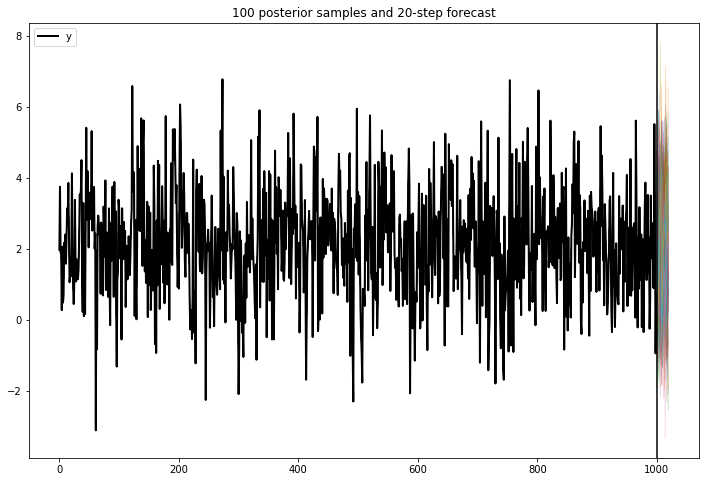

In [14]:
vfit.plot_sample_paths(N=100, true_y=y, fc_steps=20)

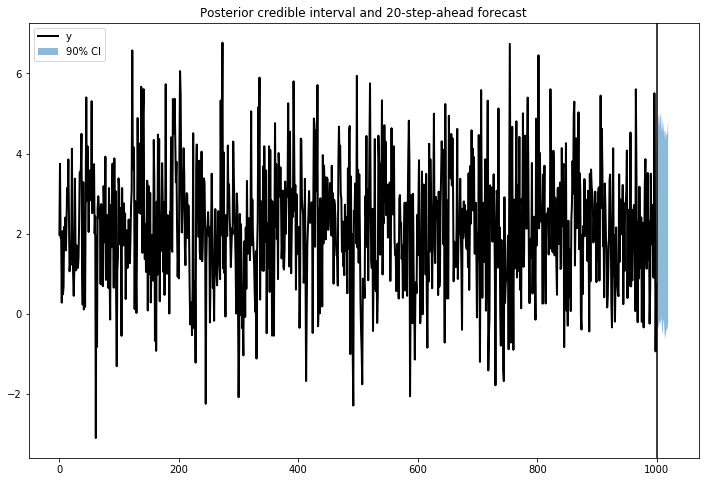

In [15]:
vfit.plot_pred_ci(N=500, α=.1, true_y=y, fc_steps=20)

## Variational inference (cold start)

For comparion, we'll do the same VI algorithm but starting at (0, I).

In [16]:
torch.manual_seed(algo_seed)
cfit = sgvb(model, y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured SGVB Inference: AR(2) model
  - Estimating elbo with M=1;
  - Minimum supremum growth heuristic (min_steps=1000, patience=20, skip=10, ε=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0
  - Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed elbo =-3914.67
       1. smoothed elbo =-3923.15
       2. smoothed elbo =-3749.37
       4. smoothed elbo =-4494.42
       8. smoothed elbo =-6381.60
      16. smoothed elbo =-8193.24
      32. smoothed elbo =-5678.36
      64. smoothed elbo =-6094.10
     128. smoothed elbo =-27008.76
     256. smoothed elbo =-10065.98
     512. smoothed elbo =-4605.36
    1024. smoothed elbo =-2501.01
    2048. smoothed elbo =-1842.75
Stopping heuristic criterion satisfied
    3370. smoothed elbo =    -1826.50
Completed 3371 iteration

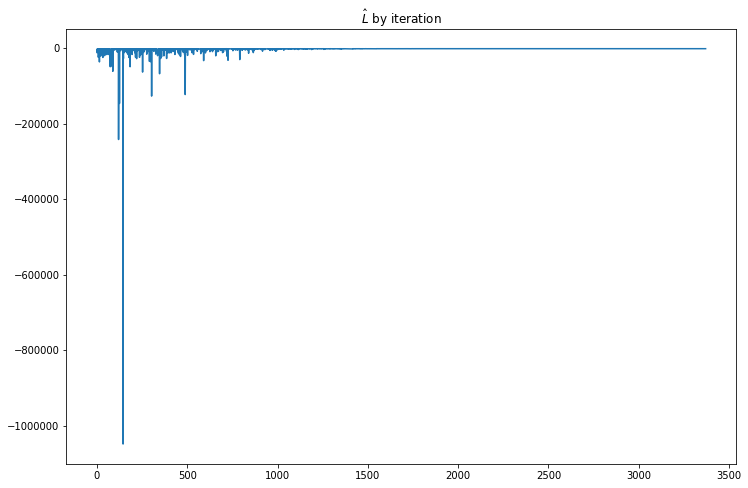

In [17]:
cfit.plot_elbos()

In [18]:
cfit.summary()

,mean,sd
μ,1.587596,0.100018
ρ1,0.150749,0.033966
ρ2,0.103908,0.026741
σ,1.483590,0.031891


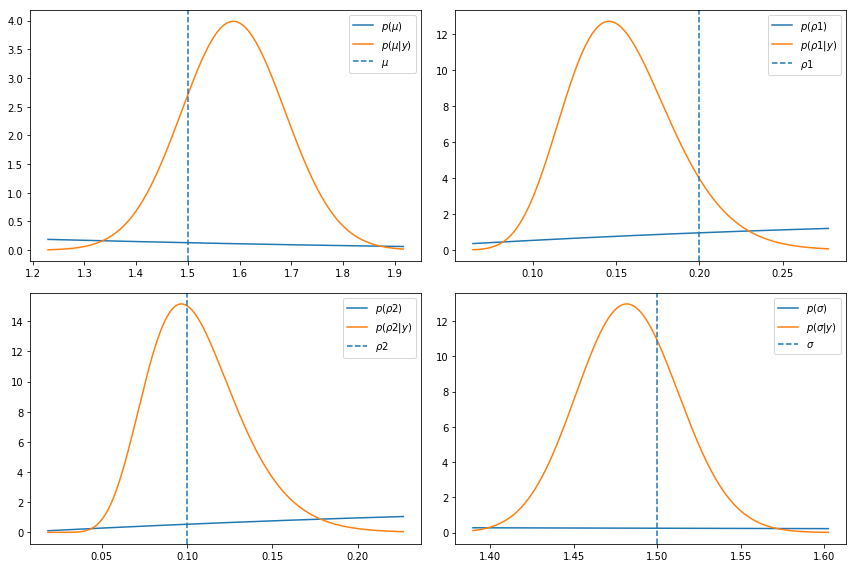

In [19]:
cfit.plot_global_marginals(**params)

### Forecasts

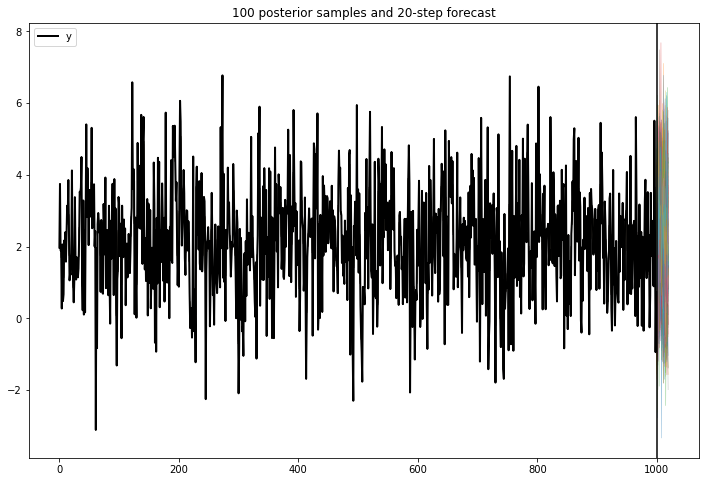

In [20]:
cfit.plot_sample_paths(N=100, true_y=y, fc_steps=20)

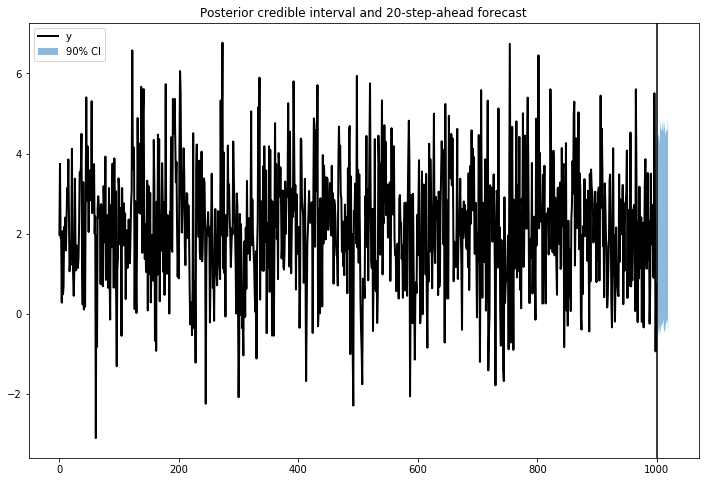

In [21]:
cfit.plot_pred_ci(N=500, α=.1, true_y=y, fc_steps=20)